# Experiments on the no2 dataset

7 input features, all continuous

No known distribution shifts in this dataset, so it is used to mimic the daily model updates.



In [43]:
import time
import os, sys, pickle, json, math, time, multiprocessing, warnings, itertools, random, warnings, gc, ast, subprocess
import copy
from collections import defaultdict, Counter, namedtuple
from math import log
from itertools import product, combinations
from random import choice, choices, sample, seed
from datetime import datetime

import gurobipy
from sklearn.metrics.pairwise import euclidean_distances
from importlib import reload
# Basics
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# Multi-processing
from joblib import Parallel, delayed
from tqdm import tqdm

# sci-kit learn
import sklearn
import sklearn.datasets as datasets
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve
from utilexp import *

pd.options.display.max_columns = 100
pd.options.display.max_rows = 150
from utilexp import *
import warnings

warnings.filterwarnings('ignore')
from expnns.preprocessor import Preprocessor, min_max_scale


In [44]:
df = pd.read_csv("../datasets/no2/no2.csv")
df = df.dropna()
df = df.replace(to_replace={'N': 0, 'P': 1})
ordinal_features = {}
discrete_features = {}
continuous_features = list(df.columns)[:-1]
CLASS = "binaryClass"

# min max scale
min_vals = np.min(df[continuous_features], axis=0)
max_vals = np.max(df[continuous_features], axis=0)
df_mm = min_max_scale(df, continuous_features, min_vals, max_vals)
columns = list(df_mm.columns)
display(df_mm)
# get X, y
X, y = df_mm.drop(columns=['binaryClass']), pd.DataFrame(df_mm['binaryClass'])

SPLIT = .2
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=SPLIT, shuffle=True,
                                                    random_state=0)
feat_var_map = {}
for i in range(len(X.columns)):
    feat_var_map[i] = [i]

,no2_concentration,cars_per_hour,temperature_at_2m,wind_speed,temperature_diff_2m_25m,wind_direction,hour_of_day,binaryClass
0,0.482404,0.844284,0.700252,0.468750,0.546392,0.202801,0.826087,0
1,0.362831,0.846118,0.629723,0.333333,0.525773,0.151261,0.565217,1
2,0.404232,0.162280,0.375315,0.062500,0.546392,0.782353,0.130435,0
3,0.611930,0.669122,0.287154,0.145833,0.680412,0.201681,0.956522,1
4,0.603835,0.803270,0.435768,0.239583,0.546392,0.176471,0.434783,1
...,...,...,...,...,...,...,...,...
495,0.596692,0.842110,0.556675,0.489583,0.453608,0.212885,0.434783,1
496,0.332732,0.569073,0.707809,0.645833,0.474227,0.582633,0.391304,1
497,0.570573,0.860087,0.599496,0.447917,0.474227,0.593838,0.565217,1
498,0.334757,0.393904,0.680101,0.020833,0.288660,0.298319,0.260870,0


In [45]:
np.random.seed(4)
idx_1 = np.sort(np.random.choice(range(500), 250))
idx_2 = np.array([i for i in range(500) if i not in idx_1])

X1 = pd.DataFrame(data=X.values[idx_1], columns=X.columns)
y1 = pd.DataFrame(data=y.values[idx_1], columns=y.columns)
X2 = pd.DataFrame(data=X.values[idx_2], columns=X.columns)
y2 = pd.DataFrame(data=y.values[idx_2], columns=y.columns)

SPLIT = .2
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, stratify=y1, test_size=SPLIT, shuffle=True,
                                                        random_state=0)


# Train models and Observe model shifts


In [46]:
# Randomdised search + 5-fold cross validation (default)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(learning_rate='adaptive', random_state=0)

# parameters
max_iter_vals = [int(i) for i in np.linspace(1000, 10000, 10)]
hidden_layer_sizes_vals = [(i) for i in range(5, 25)]
batch_size_vals = [8, 16, 32, 64]
learning_rate_init_vals = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]

#distributions = dict(max_iter=max_iter_vals, hidden_layer_sizes=hidden_layer_sizes_vals)
distributions = dict(hidden_layer_sizes=hidden_layer_sizes_vals,
                     batch_size=batch_size_vals,
                     learning_rate_init=learning_rate_init_vals,
                     max_iter=max_iter_vals, )

#nns = RandomizedSearchCV(nn, distributions, scoring='f1_macro')
#nns = RandomizedSearchCV(nn, distributions, scoring='accuracy')
#search = nns.fit(X, y)
#print(search.best_params_)


{'max_iter': 2000, 'learning_rate_init': 0.005, 'hidden_layer_sizes': 8, 'batch_size': 16}


In [47]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=16, learning_rate_init=0.005, batch_size=8,
                    max_iter=2000, random_state=0)

# 5-fold cross validation
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, f1_score, precision_score

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
scores = cross_validate(clf, X, y, scoring=scoring)
for name in list(scores.keys()):
    if name == 'fit_time' or name == 'score_time':
        continue
    print("%0.2f %s with a std of %0.2f" % (scores[name].mean(), name, scores[name].std()))

clf = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=16, learning_rate_init=0.005, batch_size=8,
                    max_iter=2000, random_state=0)

clf.fit(X1_train, y1_train)
resres = clf.predict(X1_test.values)
print('\n', classification_report(y1_test, resres, target_names=[f'bad credit (0)', f'good credit (1)'], digits=3))
resres = clf.predict(X1_train.values)
print('\n', classification_report(y1_train, resres, target_names=[f'bad credit (0)', f'good credit (1)'], digits=3))


0.61 test_accuracy with a std of 0.04
0.62 test_precision_macro with a std of 0.05
0.61 test_recall_macro with a std of 0.04
0.61 test_f1_macro with a std of 0.04

                  precision    recall  f1-score   support

 bad credit (0)      0.700     0.538     0.609        26
good credit (1)      0.600     0.750     0.667        24

       accuracy                          0.640        50
      macro avg      0.650     0.644     0.638        50
   weighted avg      0.652     0.640     0.637        50


                  precision    recall  f1-score   support

 bad credit (0)      0.785     0.716     0.749       102
good credit (1)      0.729     0.796     0.761        98

       accuracy                          0.755       200
      macro avg      0.757     0.756     0.755       200
   weighted avg      0.758     0.755     0.755       200



In [57]:
from joblib import dump, load

#dump(clf, 'no2.joblib')


['no2.joblib']

# Experiments: computing counterfactuals

#### Procedures

These procedures are covered by UtilExp class

1. Train M on D1
2. Get delta-min, build M+ and M-: incrementally train M 5 times, using different 10% of D2 each time, then get the maximum inf-distance between the incremented models and M. Construct M+ and M- using delta-min
3. Get M2: incrementally train M on D2
4. Select test instances: randomly select 50 D1 instances to explain, clf(x)=0, desired class=1
5. Report metrics using each baseline

#### Metrics
- Proximity: normalised L1: "Scaling Guarantees for Nearest CEs" page 7
- Sparsity: L0
- Validity-delta: percentage of test instances that 1) have counterfactuals valid on m1, 2) counterfactuals valid on M+ and M- under delta_min
- Validity-m2: percentage of test instances that 1) have counterfactual(s), 2) these counterfactual(s) are all valid on both m1 and m2
- LOF: average LOF score

In [58]:
from joblib import dump, load

clf = load("no2.joblib")

gurobipy.setParam("FeasibilityTol", 1e-09)
gurobipy.setParam("OptimalityTol", 1e-09)
gurobipy.setParam("IntFeasTol", 1e-05)


In [59]:
util_exp = UtilExp(clf, X1, y1, X2, y2, columns, ordinal_features, discrete_features, continuous_features, feat_var_map, num_test_instances=200, gap=0.15)
print(util_exp.delta_max)
print(util_exp.delta_min)


0.11449453866860582
0.020924421229148754


In [60]:
valids = util_exp.verify_soundness()
print(len(valids))

percentage of sound model changes: 0.4424778761061947
50


In [61]:
valids = util_exp.verify_soundness(update_test_instances=True)

percentage of sound model changes: 0.4424778761061947
test instances updated to sound (x, Delta) pairs, length: 50


In [62]:
# OURS-ROBUST
ours_robust_ces = util_exp.run_ours_robust()
util_exp.evaluate_ces(ours_robust_ces)

50it [00:06,  7.42it/s]


total computation time in s: 6.737000465393066
found: 1.0
average normalised L1: 0.058784118051772395
average normalised L0: 0.23737999999999992
average lof score: 1.0
counterfactual validity: 1.0
delta validity: 1.0
m2 validity: 1.0


In [98]:
#np.save("./results/no-milp-r.npy", ours_robust_ces)
#ours_robust_ces = list(np.load("./results/no-milp-r.npy"))

In [63]:
# OURS-NON-ROBUST
ours_non_robust_ces = util_exp.run_ours_non_robust()
util_exp.evaluate_ces(ours_non_robust_ces)

50it [00:00, 98.23it/s]


total computation time in s: 0.5100002288818359
found: 1.0
average normalised L1: 0.0323082285676768
average normalised L0: 0.19733999999999996
average lof score: 1.0
counterfactual validity: 1.0
delta validity: 0.0
m2 validity: 0.32


In [97]:
#np.save("./results/no-milp.npy", ours_non_robust_ces)
#ours_non_robust_ces = list(np.load("./results/no-milp.npy"))

In [64]:
# ROAR
roar_ces = util_exp.run_ROAR(labels=(1,))
util_exp.evaluate_ces(roar_ces)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  1.36it/s]

0it [00:00, ?it/s]
1it [00:00,  1.53it/s]

0it [00:00, ?it/s]
1it [00:00,  1.56it/s]

0it [00:00, ?it/s]
1it [00:00,  1.62it/s]

0it [00:00, ?it/s]
1it [00:00,  2.44it/s]

0it [00:00, ?it/s]
1it [00:00,  2.87it/s]

0it [00:00, ?it/s]
1it [00:00,  3.03it/s]

0it [00:00, ?it/s]
1it [00:00,  4.10it/s]

0it [00:00, ?it/s]
1it [00:00,  6.13it/s]

0it [00:00, ?it/s]
1it [00:00,  8.77it/s]
1it [00:04,  4.44s/it]
0it [00:00, ?it/s]
1it [00:00,  1.72it/s]

0it [00:00, ?it/s]
1it [00:00,  1.76it/s]

0it [00:00, ?it/s]
1it [00:00,  1.79it/s]

0it [00:00, ?it/s]
1it [00:00,  1.95it/s]

0it [00:00, ?it/s]
1it [00:00,  2.26it/s]

0it [00:00, ?it/s]
1it [00:00,  4.20it/s]

0it [00:00, ?it/s]
1it [00:00,  3.53it/s]

0it [00:00, ?it/s]
1it [00:00,  4.37it/s]

1it [00:00, 45.46it/s]
2it [00:08,  4.01s/it]
0it [00:00, ?it/s]
1it [00:00,  1.71it/s]

0it [00:00, ?it/s]
1it [00:00,  1.49it/s]

0it [00:00, ?it/s]
1it [00:00,  1.61it/s]

0it [00:00

total computation time in s: 199.37599897384644
found: 1.0
average normalised L1: 0.07430251286611084
average normalised L0: 0.8829999999999996
average lof score: 1.0
counterfactual validity: 0.88
delta validity: 0.1
m2 validity: 0.34


In [96]:
#np.save("./results/no-roar.npy", roar_ces)
#roar_ces = list(np.load("./results/no-roar.npy"))

In [65]:
# PROTOTYPES
proto_ces = util_exp.run_proto(kap=0)
util_exp.evaluate_ces(proto_ces)

No encoder specified. Using k-d trees to represent class prototypes.
50it [13:12, 15.84s/it]


total computation time in s: 792.1829304695129
found: 1.0
average normalised L1: 0.03640879738084055
average normalised L0: 0.46294000000000013
average lof score: 1.0
counterfactual validity: 1.0
delta validity: 0.0
m2 validity: 0.32


In [95]:
#np.save("./results/no-proto.npy", proto_ces)
#proto_ces = list(np.load("./results/no-proto.npy"))

In [87]:
# PROTOTYPES-robustness-boosted
proto_ces_robust = util_exp.run_proto_robust(kap=0)
util_exp.evaluate_ces(proto_ces_robust)

0it [00:00, ?it/s]No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
1it [01:20, 80.56s/it]No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
2it [03:00, 92.00s/it]No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to 

total computation time in s: 4104.858039855957
found: 1.0
average normalised L1: 0.06864553751981217
average normalised L0: 0.4772600000000001
average lof score: 1.0
counterfactual validity: 1.0
delta validity: 1.0
m2 validity: 1.0


In [94]:
#np.save("./results/no-proto-r.npy", proto_ces_robust)
#proto_ces_robust = list(np.load("./results/no-proto-r.npy"))

In [82]:
# WACHTER CF
wachter_ces = util_exp.run_wachter(target_proba=0.56, max_lam_steps=10)
util_exp.evaluate_ces(wachter_ces)


50it [05:18,  6.38s/it]


total computation time in s: 318.87135076522827
found: 1.0
average normalised L1: 0.03473534144446282
average normalised L0: 0.9199199999999998
average lof score: 1.0
counterfactual validity: 1.0
delta validity: 0.0
m2 validity: 0.32


In [93]:
#np.save("./results/no-wachter.npy", wachter_ces)
#wachter_ces = list(np.load("./results/no-wachter.npy"))

In [88]:
# WACHTER CF - robustness-boosted
wachter_ces_rob = util_exp.run_wachter_robust(target_proba=0.56)
util_exp.evaluate_ces(wachter_ces_rob)


50it [1:32:24, 110.90s/it]


total computation time in s: 5544.804674386978
found: 1.0
average normalised L1: 0.08415527430633789
average normalised L0: 0.98856
average lof score: 1.0
counterfactual validity: 1.0
delta validity: 1.0
m2 validity: 1.0


In [92]:
#np.save("./results/no-wachter-r.npy", wachter_ces_rob)
#wachter_ces_rob = list(np.load("./results/no-wachter-r.npy"))

In [90]:
delta = util_exp.delta_max
print(np.arange(delta/10, delta*1.01, delta/10))
plot_x = np.arange(0.0, 1.01, 0.1)
print(delta)
print(plot_x)


[0.01144945 0.02289891 0.03434836 0.04579782 0.05724727 0.06869672
 0.08014618 0.09159563 0.10304508 0.11449454]
0.11449453866860582
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [91]:
plot_x = [str(i) + "*$\delta$" for i in np.round(np.arange(0., 1.00001, 0.1), 1)]
print(plot_x)
plot_x_num = np.round(np.arange(0, 1.00001, 0.1), 1)

['0.0*$\\delta$', '0.1*$\\delta$', '0.2*$\\delta$', '0.3*$\\delta$', '0.4*$\\delta$', '0.5*$\\delta$', '0.6*$\\delta$', '0.7*$\\delta$', '0.8*$\\delta$', '0.9*$\\delta$', '1.0*$\\delta$']


In [79]:
def evaluate_ces_validity_plot(test_instances, ces, target_delta=0.05):
    deltas = np.concatenate((np.array([0]),np.arange(target_delta/10, target_delta*1.01, target_delta/10)))
    delta_vals = []
    for delta in deltas:
        delta_val = 0
        nodes = build_inn_nodes(util_exp.clf, util_exp.num_layers)
        weights, biases = build_inn_weights_biases(util_exp.clf, util_exp.num_layers, delta, nodes)
        inn_delta = Inn(util_exp.num_layers, delta, nodes, weights, biases)
        for i, x in enumerate(test_instances):
            if ces[i] is None:
                continue
            y_prime = 1 if util_exp.clf.predict(x.reshape(1, -1))[0] == 0 else 0
            this_solver = OptSolver(util_exp.dataset, inn_delta, y_prime, x, mode=1, M=10000, x_prime=ces[i])
            if this_solver.compute_inn_bounds()[0] == 1:
                delta_val += 1
        delta_vals.append(delta_val / len(test_instances))
    return delta_vals


In [99]:
delta_vals_roar = evaluate_ces_validity_plot(util_exp.test_instances, roar_ces, target_delta=util_exp.delta_min)
delta_vals_ours_rob = evaluate_ces_validity_plot(util_exp.test_instances, ours_robust_ces,
                                                     target_delta=util_exp.delta_min)
delta_vals_ours_non_rob = evaluate_ces_validity_plot(util_exp.test_instances, ours_non_robust_ces,
                                                     target_delta=util_exp.delta_min)
delta_vals_wachter = evaluate_ces_validity_plot(util_exp.test_instances, wachter_ces, target_delta=util_exp.delta_min)
delta_vals_wachter_rob = evaluate_ces_validity_plot(util_exp.test_instances, wachter_ces_rob, target_delta=util_exp.delta_min)
delta_vals_proto = evaluate_ces_validity_plot(util_exp.test_instances, proto_ces, target_delta=util_exp.delta_min)
delta_vals_proto_rob = evaluate_ces_validity_plot(util_exp.test_instances, proto_ces_robust, target_delta=util_exp.delta_min)

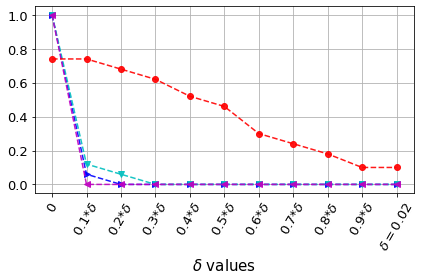

In [155]:
fig, ax = plt.subplots()
ax.plot(plot_x_num, delta_vals_wachter, "b>--", label="WACHTER", alpha=0.9)
#ax.plot(plot_x_num, delta_vals_wachter_rob, "b>-", label="WACHTER-R", alpha=0.9)
ax.plot(plot_x_num, delta_vals_proto, "cv--", label="PROTO", alpha=0.9)
#ax.plot(plot_x_num, delta_vals_proto_rob, "cv-", label="PROTO-R", alpha=0.9)
ax.plot(plot_x_num, delta_vals_ours_non_rob, "m<--", label="MILP", alpha=0.9)
#ax.plot(plot_x_num, delta_vals_ours_rob, "m<-", label="MILP-R", alpha=0.9)
ax.plot(plot_x_num, delta_vals_roar, "ro--", label="ROAR", alpha=0.9)
ax.set_xticks(np.arange(0., 1.01, 0.1))
labels = [item.get_text() for item in ax.get_xticklabels()]
for i in range(len(labels)):
    labels[i] = plot_x[i]
    if i == len(labels) - 1:
        labels[i] = "$\delta=$" + str(np.round(util_exp.delta_min, 2))
    if i == 0:
        labels[i] = str(0)
ax.set_xticklabels(labels, fontsize=13)
ylabels = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels, fontsize=13)

ax.grid()
#ax.legend()
plt.xticks(rotation=60)
#ax.set_ylabel("$\Delta$-validity", fontsize=15)
ax.set_xlabel("$\delta$ values", fontsize=15)
fig.tight_layout()
fig.savefig("./plots/delta-val-no2.png", dpi=300)

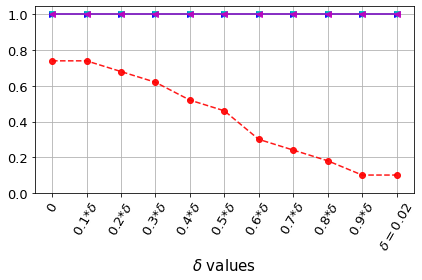

In [154]:
fig, ax = plt.subplots()
#ax.plot(plot_x_num, delta_vals_wachter, "b>--", label="WACHTER", alpha=0.9)
ax.plot(plot_x_num, delta_vals_wachter_rob, "b>-", label="WACHTER-R", alpha=0.9)
#ax.plot(plot_x_num, delta_vals_proto, "cv--", label="PROTO", alpha=0.9)
ax.plot(plot_x_num, delta_vals_proto_rob, "cv-", label="PROTO-R", alpha=0.9)
#ax.plot(plot_x_num, delta_vals_ours_non_rob, "m<--", label="MILP", alpha=0.9)
ax.plot(plot_x_num, delta_vals_ours_rob, "m<-", label="MILP-R", alpha=0.9)
ax.plot(plot_x_num, delta_vals_roar, "ro--", label="ROAR", alpha=0.9)
ax.set_xticks(np.arange(0., 1.01, 0.1))
labels = [item.get_text() for item in ax.get_xticklabels()]
for i in range(len(labels)):
    labels[i] = plot_x[i]
    if i == len(labels) - 1:
        labels[i] = "$\delta=$" + str(np.round(util_exp.delta_min, 2))
    if i == 0:
        labels[i] = str(0)
ax.set_xticklabels(labels, fontsize=13)
ylabels = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels, fontsize=13)
ax.grid()
#ax.legend()
plt.xticks(rotation=60)
#ax.set_ylabel("$\Delta$-validity", fontsize=15)
ax.set_xlabel("$\delta$ values", fontsize=15)
fig.tight_layout()
fig.savefig("./plots/robust-delta-val-no2.png", dpi=300)

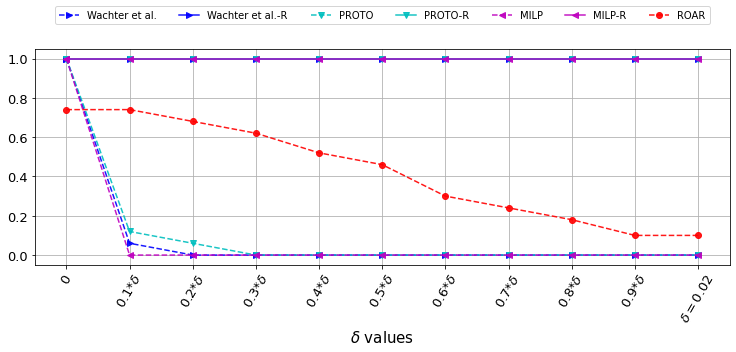

In [156]:
fig, ax = plt.subplots()
ax.plot(plot_x_num, delta_vals_wachter, "b>--", label="Wachter et al.", alpha=0.9)
ax.plot(plot_x_num, delta_vals_wachter_rob, "b>-", label="Wachter et al.-R", alpha=0.9)
ax.plot(plot_x_num, delta_vals_proto, "cv--", label="PROTO", alpha=0.9)
ax.plot(plot_x_num, delta_vals_proto_rob, "cv-", label="PROTO-R", alpha=0.9)
ax.plot(plot_x_num, delta_vals_ours_non_rob, "m<--", label="MILP", alpha=0.9)
ax.plot(plot_x_num, delta_vals_ours_rob, "m<-", label="MILP-R", alpha=0.9)
ax.plot(plot_x_num, delta_vals_roar, "ro--", label="ROAR", alpha=0.9)
ax.set_xticks(np.arange(0., 1.01, 0.1))
labels = [item.get_text() for item in ax.get_xticklabels()]
for i in range(len(labels)):
    labels[i] = plot_x[i]
    if i == len(labels) - 1:
        labels[i] = "$\delta=$" + str(np.round(util_exp.delta_min, 2))
    if i == 0:
        labels[i] = str(0)
ax.set_xticklabels(labels, fontsize=13)
ylabels = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels, fontsize=13)
ax.grid()
ax.legend(bbox_to_anchor=(0., 1.02, 1, .102), loc='lower left',
                      ncol=7, mode="expand", borderaxespad=2)
plt.xticks(rotation=60)
#ax.set_ylabel("$\Delta$-validity", fontsize=15)
ax.set_xlabel("$\delta$ values", fontsize=15)
fig.tight_layout()
fig.set_size_inches(11, 6)
fig.savefig("./plots/legends.jpg", dpi=600)